In [1]:
# Analysis of transcription status of an herbarium collection
# Compares total occurrence records, records with images, and records missing key data
# Reads data from a Darwin Core Archive

import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set up constants
#COLLECTION_CODE = 'BRIT'
#COLLECTION_CODE = 'VDB'
COLLECTION_CODE = 'NLU'
# Collection prefix is the string that prepends the digits in a catalogNumber
#COLLECTION_PREFIX = 'BRIT'
COLLECTION_PREFIX = 'NLU'
DwC_ARCHIVE_PATH = COLLECTION_CODE + '-DwC_Archive/'
DATE = datetime.datetime.today().strftime("%Y-%m-%d")

In [3]:
# load the occurrences file from a Darwin Core Archive
df_occurrences = pd.read_csv(DwC_ARCHIVE_PATH + "occurrences.csv", low_memory=False)
# load the images file from a Darwin Core Archive
df_images = pd.read_csv(DwC_ARCHIVE_PATH + "images.csv", low_memory=False)

In [4]:
# Merge the occurrence and image records
df_merged = pd.merge(df_occurrences, df_images, how='left', left_on='id', right_on='coreid')

In [5]:
# Make sure the dataset has the number of row and columns you expect
df_merged.shape

(382685, 104)

In [6]:
# Check for duplicates
# This will occur when there is more than one image per occurrence
df_dups = df_merged[df_merged.duplicated(['id'])]
df_dups.shape

(0, 104)

In [7]:
# Save dups if desired
#df_dups.to_csv('duplicates.csv')

In [8]:
# Create column based on collectionNumber
# with the collection prefix removed
df_merged['catalogNumber_num'] = df_merged.apply(lambda row: str(row.catalogNumber).strip(COLLECTION_PREFIX), axis=1)

In [9]:
# Convert the column values to numerical
# TODO find a better way to convert than 'coerce', this can introduce problems or overlook problems
df_merged['catalogNumber_num'] = pd.to_numeric(df_merged['catalogNumber_num'], errors='coerce')

In [10]:
# Fill NA/NaN values with 0
df_merged['catalogNumber_num'] = df_merged['catalogNumber_num'].fillna(0)

In [11]:
# filter bad values if needed
# in the BRIT collection, some catalog numbers were entered incorrectly
# with more than the correct number of digits
df_merged_filtered = df_merged.loc[df_merged['catalogNumber_num'] < 1000000]

In [12]:
# check values of catalogNumber_num
df_merged_filtered['catalogNumber_num'].nlargest(n=10)

376297    473535.0
382644    457567.0
382645    457566.0
382646    457565.0
382608    457563.0
382607    457562.0
382662    457219.0
382663    457218.0
382664    457217.0
382665    457216.0
Name: catalogNumber_num, dtype: float64

In [13]:
# create increments for graph bins
# need to set bin size instead of bin count because 
# the filtering of each data set was making the 
# bin size change for each dataset
cN_max = int(df_merged_filtered['catalogNumber_num'].nlargest(n=1))
cN_bins = [n*10000 for n in range(0, int(cN_max/10000)+1)]

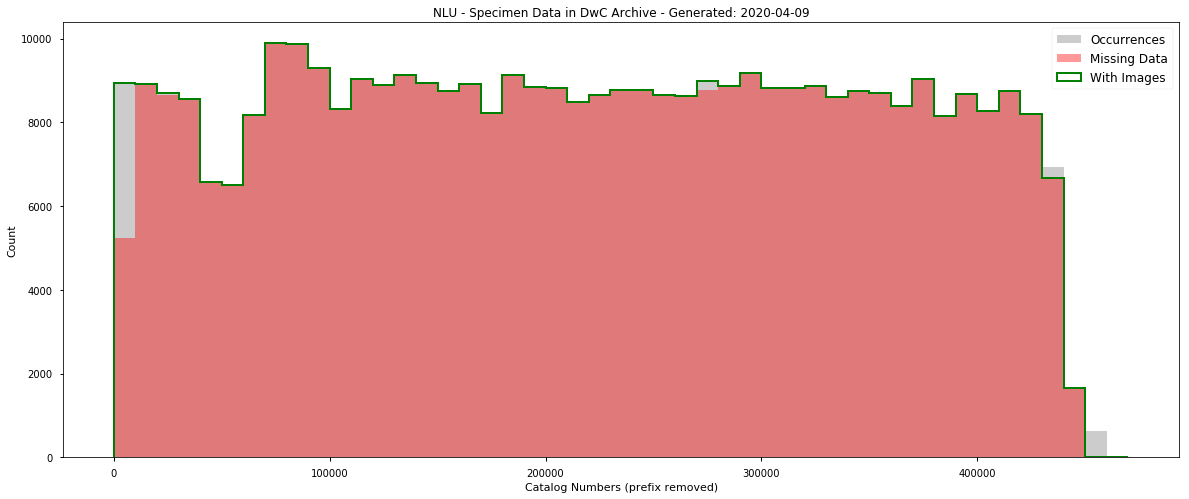

In [14]:
# Graph the results
sns.set_context("notebook")
plt.figure(figsize=(20,8))

# create a Dataframe that will be filtered for the graph
df_plot = df_merged_filtered
# Graph occurrences
sns.distplot(df_plot['catalogNumber_num'], kde=False, bins=cN_bins, color='gray', label='Occurrences')
# Find records lacking information
# Records lacking recordedBy
df_null_recordedBy = df_merged_filtered[df_merged_filtered['recordedBy'].isnull()]
# Records lacking recordedBy and scientificName
df_null_sN_and_rB = df_null_recordedBy[df_null_recordedBy['scientificName'].isnull()]
# Graph records lacking data 
df_plot = df_null_sN_and_rB
sns.distplot(df_plot['catalogNumber_num'], kde=False, color='red', bins=cN_bins, label='Missing Data')
# Filter occurrences with images
df_plot = df_merged_filtered[df_merged_filtered['accessURI'].notnull()]
# Graph records with images
sns.distplot(df_plot['catalogNumber_num'], kde=False, bins=cN_bins, label='With Images', hist_kws={"histtype": "step", "linewidth": 2,"alpha": 1, "color": "green"})
# Add plot information
plt.legend(prop={'size': 12})
plt.title(f'{COLLECTION_CODE} - Specimen Data in DwC Archive - Generated: {DATE}')
plt.xlabel('Catalog Numbers (prefix removed)')
plt.ylabel('Count')
# Write out graph image
plt.savefig(COLLECTION_CODE + '-catalogNumber_distribution.png', dpi=400)